In [9]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,utils
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])   #needed to do grayscale cob=nversion before normalizing to tensor
trainset=datasets.CIFAR10('CIFAR10/',train=True,transform=transform,download=True)
train_loader=DataLoader(trainset,batch_size=64,shuffle=True) #use all three channels

testset=datasets.CIFAR10('CIFAR10/',train=False,transform=transform,download=True)
test_loader=DataLoader(testset,batch_size=64,shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 32, 32])
torch.Size([64])


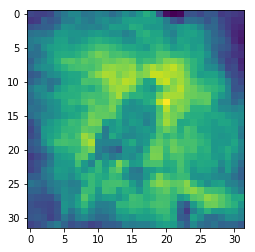

In [11]:
image,label=next(iter(train_loader))
print(image.size())
print(label.size())
plt.imshow(image[0][0,:])

In [12]:
label

tensor([ 2,  0,  5,  6,  7,  8,  9,  2,  2,  0,  1,  2,  7,  9,
         8,  6,  4,  3,  3,  1,  1,  0,  8,  8,  5,  5,  8,  8,
         9,  6,  6,  1,  7,  2,  3,  6,  2,  2,  6,  2,  9,  0,
         5,  6,  2,  2,  1,  3,  8,  7,  4,  1,  1,  0,  8,  0,
         8,  5,  4,  7,  8,  2,  4,  0])

In [13]:
class inception_(torch.nn.Module):
    
    def __init__(self,input_):
        super(inception_,self).__init__()
           
        self.conv1_1_1=torch.nn.Conv2d(input_,16,kernel_size=1)
        
        self.conv1_1_2=torch.nn.Conv2d(input_,16,kernel_size=1)
        self.conv5_5_2=torch.nn.Conv2d(16,24,kernel_size=5,padding=2)
        
        self.conv1_1_3=torch.nn.Conv2d(input_,16,kernel_size=1) 
        self.conv3_3_1_3=torch.nn.Conv2d(16,24,kernel_size=3,padding=1)
        self.conv3_3_2_3=torch.nn.Conv2d(24,24,kernel_size=3,padding=1)
        
        #self.avgpool4=torch.nn.AvgPool2d(kernel_size=3,stride=1,padding=1)
        self.conv1_1_4=torch.nn.Conv2d(input_,24,kernel_size=1)

   
    def forward(self,x): 
        
        #input_=x.size(0)
        #x=x.view(-1)  ?
        x1_1=self.conv1_1_1(x)
        
        x5_5=self.conv1_1_2(x)
        x5_5=self.conv5_5_2(x5_5)
        
        x3_3=self.conv1_1_3(x)
        x3_3=self.conv3_3_1_3(x3_3)
        x3_3=self.conv3_3_2_3(x3_3)
        
        xpool=F.avg_pool2d(x,kernel_size=3,stride=1,padding=1)
        xpool=self.conv1_1_4(xpool)
        
        outputs=[x1_1,x5_5,x3_3,xpool]
        
        return torch.cat(outputs,1)
        
    

In [14]:
class Network(torch.nn.Module):
    
    def __init__(self):
        super(Network,self).__init__()
        self.conv1=torch.nn.Conv2d(3,10,kernel_size=5)
        self.conv2=torch.nn.Conv2d(88,20,kernel_size=5)
        
        self.incept1=inception_(input_=10)
        self.incept2=inception_(input_=20)
        
        self.mp=torch.nn.MaxPool2d(2)
        self.fc=torch.nn.Linear(2200,1000)
        self.dropout0=torch.nn.Dropout(p=0.2)
        self.fc1=torch.nn.Linear(1000,500)
        self.dropout1=torch.nn.Dropout(p=0.2)
        self.fc2=torch.nn.Linear(500,200)
        self.dropout2=torch.nn.Dropout(p=0.2)
        self.fc3=torch.nn.Linear(200,10)
        
        
        
    def forward(self,x):
        
        input_size=x.size(0)
        x=F.relu(self.mp(self.conv1(x)))
        
        x=self.incept1(x)
        
        x=F.relu(self.mp(self.conv2(x)))
        
        x=self.incept2(x)
        
        x=x.view(input_size,-1)
        
        x=F.relu(self.fc(x))
        x=self.dropout0(x)
        x=F.relu(self.fc1(x))
        x=self.dropout1(x)
        x=F.relu(self.fc2(x))  
        x=self.dropout2(x)
        x=F.relu(self.fc3(x))
        y_pred=x     
        
        return y_pred

model=Network()    
    

In [15]:
epochs=10
criterion=torch.nn.CrossEntropyLoss()  #if increase the lr to 0.1, it kicks to local min and stays
optimizer=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)  #had to change from SGD to Adam but later noy much difference
lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [16]:
#torch.set_printoptions(precision=2)
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0

    for epoch in range(epochs):

        for image,label in iter(train_loader):

            #input.resize_(input.size()[0], 784)   take to forward
            y_pred=model(image)   #this is 64 (bacth_size)*10

            if(count==0): print(y_pred.size(),label.size())
            loss=criterion(y_pred,label)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(label.size()[0])
            _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            acc=(label==y_pred_).sum().item()    #/label.size()[0]
            sum_acc=sum_acc+acc
            if(count%200==0): print('epoch',epoch+1,'/',epochs,'running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))

        check_loss=(loss_running/count_batch)
        lr_scheduler_.step(check_loss)

train_function(train_loader)

torch.Size([64, 10]) torch.Size([64])
epoch 1 / 10 running_loss: 0.03590712681412697 Accuracy 12.890625
epoch 1 / 10 running_loss: 0.03487946182955057 Accuracy 17.62890625
epoch 1 / 10 running_loss: 0.0330093618730704 Accuracy 22.450520833333332
epoch 2 / 10 running_loss: 0.031199934552395982 Accuracy 26.798561151079138
epoch 2 / 10 running_loss: 0.029653906307728673 Accuracy 30.430635476607456
epoch 2 / 10 running_loss: 0.028457581181500838 Accuracy 33.333333333333336
epoch 2 / 10 running_loss: 0.02739223145176113 Accuracy 36.046096122923
epoch 3 / 10 running_loss: 0.026515946818196964 Accuracy 38.25363622145762
epoch 3 / 10 running_loss: 0.025680470470135032 Accuracy 40.29225743675285
epoch 3 / 10 running_loss: 0.024995402565558225 Accuracy 42.05185138854141
epoch 3 / 10 running_loss: 0.024377311453009726 Accuracy 43.632021833068
epoch 4 / 10 running_loss: 0.023818034037424073 Accuracy 45.02267751016578
epoch 4 / 10 running_loss: 0.023262276126966474 Accuracy 46.389904725243
epoch 4 

In [17]:
#torch.set_printoptions(precision=2)
def test_function(test_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0

    for input,label in iter(test_loader):
        model.eval()

        #input.resize_(input.size()[0], 784)   take to forward
        y_pred=model(input)   #this is 64 (bacth_size)*10

        #if(count==0): print(y_pred.size(),label.size())
        loss=criterion(y_pred,label)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
        loss_running=loss_running+loss.item()
        count=count+1

        count_batch=count_batch+(label.size()[0])
        _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

        acc=(label==y_pred_).sum().item()    #/label.size()[0]
        sum_acc=sum_acc+acc
        if(count%100==0): print('running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))




test_function(test_loader)   # w/o convnet :result show over fitting on train 64%, but overall 50% on test is not too bad wihtout convnet
#w/ convnet just after 5 epoch training the test got to 63% (50% train)
#after 10 epoch test get to 66% pretty good without big networks

#CiFAR10 with inception better in training improve to 64% but not much better for test at 64% (may be need derop out and more fc)

#after more fc on top of inception got to 70% test, 

running_loss: 0.014409492444247007 Accuracy 70.875
